# Transcription Factor Project
**Robin Anwyl, UCSD Subramaniam Lab, Winter Quarter 2025**

**Goal:** Analyze the hiPSC Perturb-seq dataset from the Mali lab (Nourreddine et al preprint) to investigate the effects of transcription factor knockouts (TF KOs)

**Guiding Questions:**
*  What TF KOs are present in the dataset? 
*  When performing clustering with the dataset - can we associate a unique set of TFs with a cluster? Is there any functional significance to these clusters?
*  What gene targets are associated with these TFs?
*  Which TFs are involved in co-regulation, and which genes are co-regulated? Which TFs are regulated by other TFs?
*  How do TFs influence chromatin remodeling? Which sets of writers and erasers are regulated by these TFs?

***

# Import statements

In [1]:
# import mudata as md
import muon as mu
import anndata as ad
import rapids_singlecell as rsc
import scanpy as sc
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, "/home/data/Mali_project/Data_Analysis_Pipeline/")
import perturb_seq_heuristic_pipeline as qc
# import requests

Note: use terminal command " watch -n 0.1 free -h " to watch how much memory is being used

# Working with the original Perturb-Seq dataset

We will read in the Perturb-seq single-cell dataset `.h5mu` file as a `MuData` object, `mdata`.

`mdata` contains two `AnnData` objects: `rna` (cell-by-gene matrix) and `crispr` (cell-by-knockout matrix)
- `rna`: 5386783 cells x 38606 features  
    - Features = expression of each human gene measured in the dataset
    - `rna.obs` = cell barcodes, `rna.var` = features = genes
- `crispr`: 5386783 cells x 35989 features
    - Features = CRISPR sgRNAs (3 sgRNAs per gene target * 11739 gene targets, plus 478 non-targeting control sgRNAs)
    - `crispr.obs` = cell barcodes, `crispr.var` = features = knockouts

We will be working with `rna` for the majority of the analysis.

In [2]:
mdata = mu.read_h5mu("/home/data/Mali_project/KOLF_Pan_Genome_Aggregate.h5mu", backed=True)
adata = mdata.mod["rna"]

## QC and Normalization

To perform QC, we will use the QC pipeline associated with this study, `perturb_seq_heuristic_pipeline.py`, along with code from `Pan_Genome_Analysis.ipynb`. First, we will assign gRNAs to cells using `protospacer_calls_per_cell.csv`.

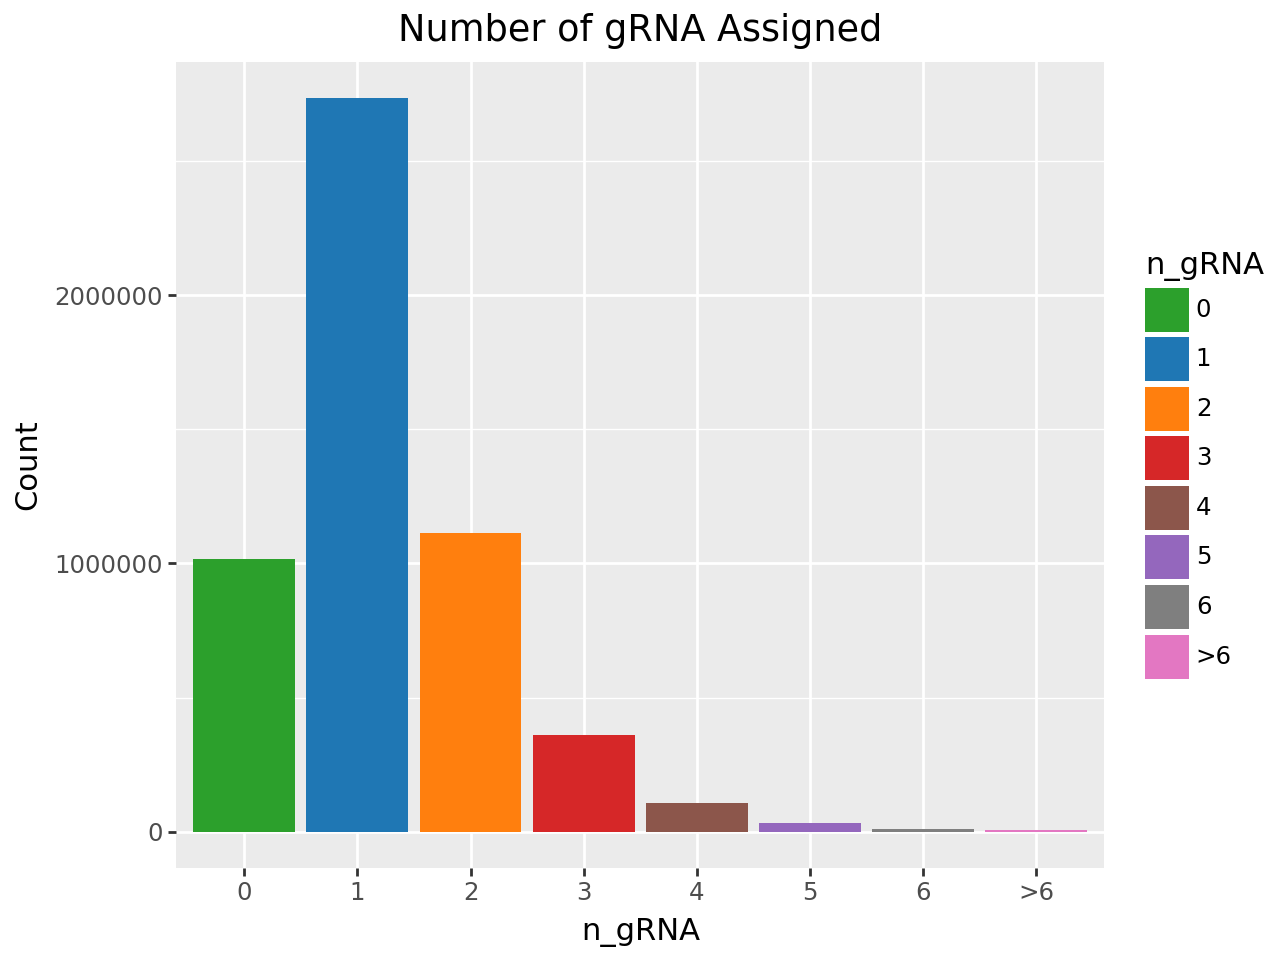

Cells without confident sgRNA calls: 18.89%
Estimated Multiplet Rate: 30.33%


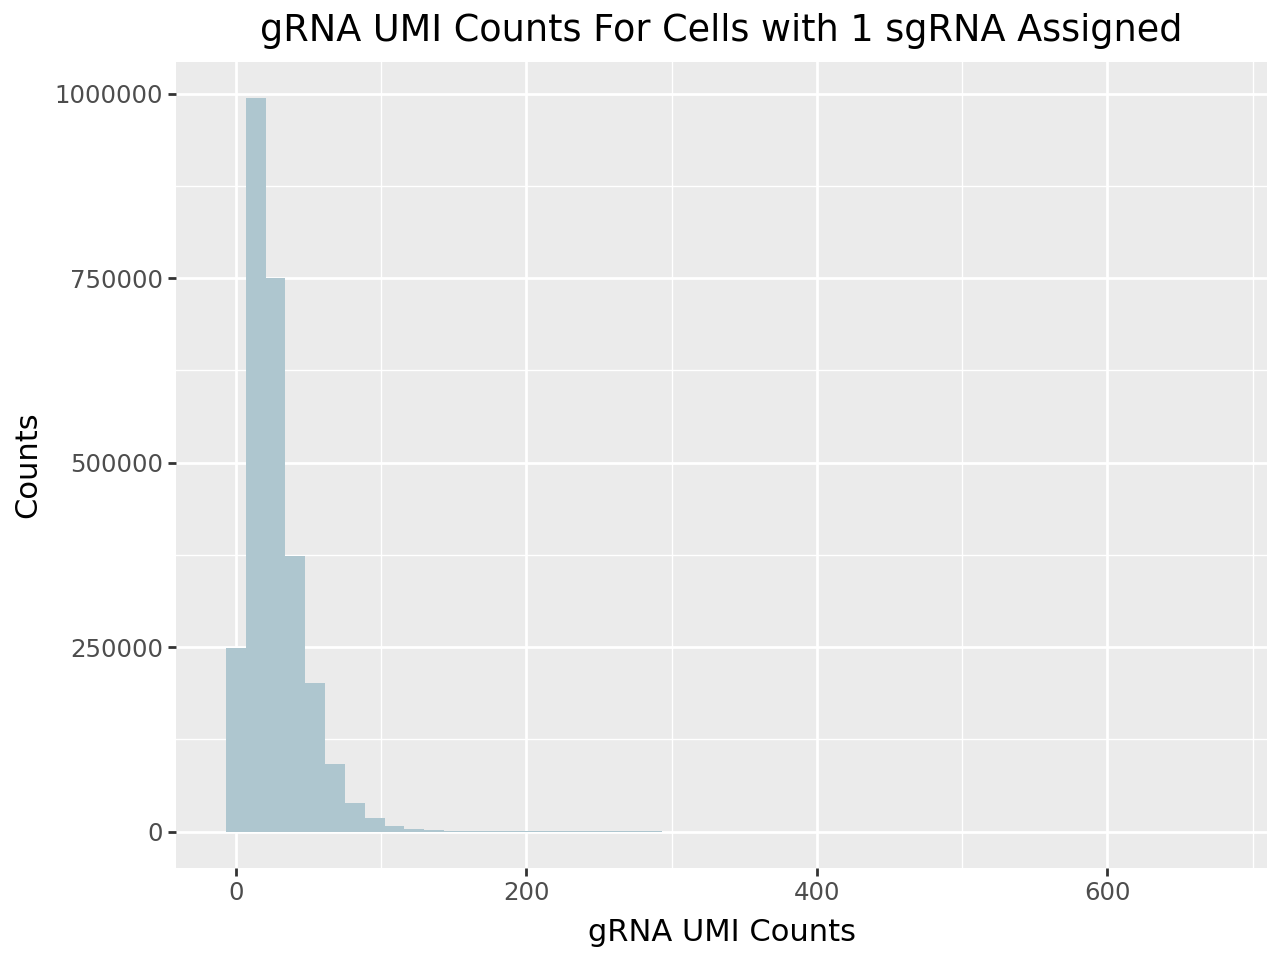

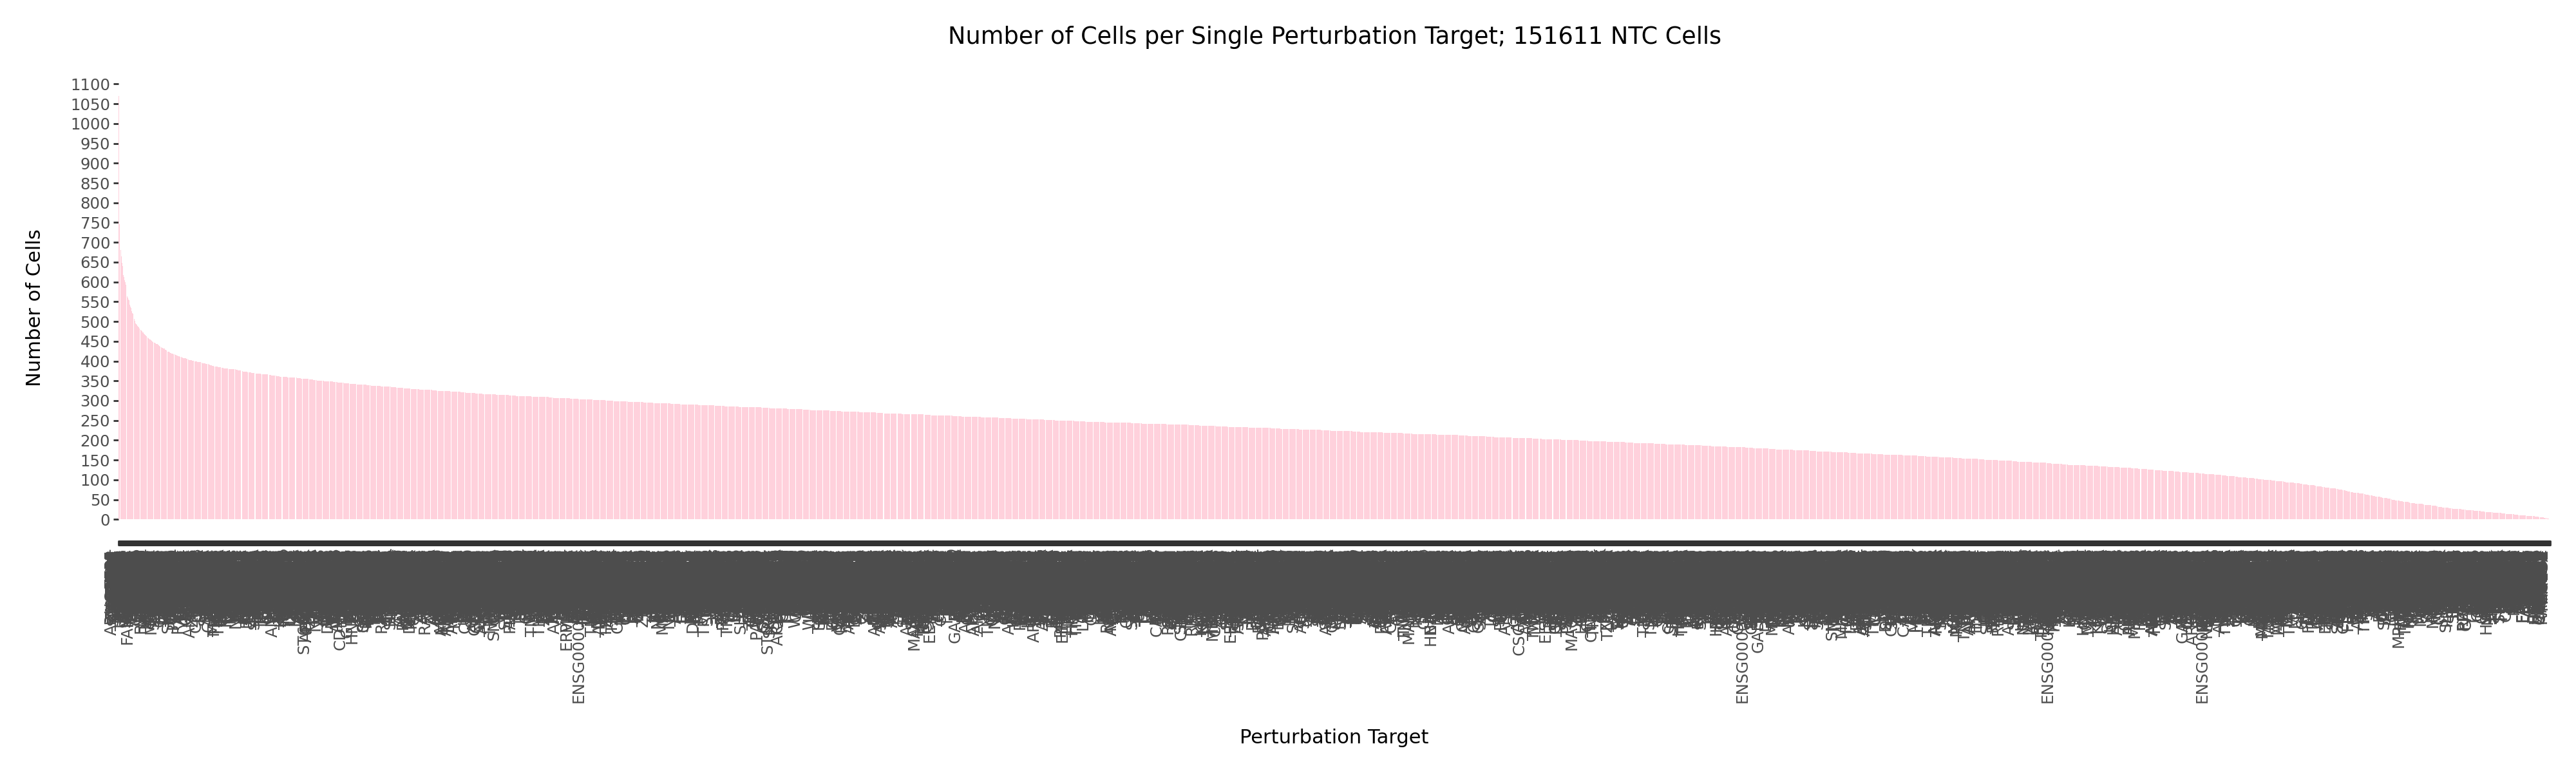

Number of perturbations with >= 50 cells with single guide assigned: 10933/11687 (93.55%)


In [3]:
protospacer_calls_file_path = "/home/data/Mali_project/protospacer_calls_per_cell.csv"
adata = qc.assign_protospacers(adata, protospacer_calls_file_path=protospacer_calls_file_path)

Now we will assign metadata using `aggregation_csv.csv`.

Note: I think the AttributeError is because the AnnData object is backed. The error persists even if I change the line that caused the error from `adata.obs["n_UMI_counts"] = adata.X.sum(axis=1)` to `adata.obs["n_UMI_counts"] = adata.X.sum(axis=1).A1`. Right now there is not enough server RAM for me to read the file into memory. The cell-by-gene AnnData object `adata` takes 129 GiB of RAM.

In [5]:
d = pd.read_csv("/home/data/Mali_project/aggregation_csv.csv")
channel_dict = {str(i+1):channel for i,channel in enumerate(d["sample_id"])}
adata = qc.assign_metadata(adata=adata,cell_type="KOLF2.1J iPSC",perturbation_type="CRISPRi Perturb-Seq",channel_dict=channel_dict)
adata.obs['n_gRNA_UMIs'] = adata.obs['n_gRNA_UMIs'].astype(str)

AttributeError: '_CSCDataset' object has no attribute 'sum'

In [6]:
adata.X

CSCDataset: backend hdf5, shape (5386783, 38606), data_dtype float32

Next, following `Pan_Genome_Analysis.ipynb`, I tried to run the `general_qc` function. The ValueError was raised because the function tried to make a copy of a backed AnnData object. However, without more RAM, it will not be possible to make a copy of `adata`.

In [11]:
adata = qc.general_qc(adata)

ValueError: To copy an AnnData object in backed mode, pass a filename: `.copy(filename='myfilename.h5ad')`. To load the object into memory, use `.to_memory()`.

## Normalization

Once QC is complete, we will save the raw data in the `raw` attribute and normalize the data.

In [ ]:
adata.raw = adata.copy() # Save raw data
rsc.get.anndata_to_GPU(adata)
# Normalize
rsc.pp.normalize_total(adata)
rsc.pp.log1p(adata)

## Cell-by-TF UMAP

After QC and normalization have been performed, we will now generate the cell-by-TF UMAP. We will subset the genes that are in the list of TFs from Lambert et al (2018). Then we will carry out feature selection, scaling, PCA, using the PCA "elbow plot" to determine which principal components to use for further analysis, computing k-nearest neighbors, and UMAP visualization.

In [ ]:
# # Get list of 1639 Lambert TFs
# lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
# tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# # Subset genes that are TFs
# filtered_genes = adata.var.index.isin(tfs)
# adata_cell_by_tf = adata[:, filtered_genes]
# # Feature selection
# rsc.pp.highly_variable_genes(adata, n_top_genes=2000) # Probably want to change n_top_genes since we only have 1639 TFs in the list
# # Scaling
# rsc.pp.scale(adata, max_value=10.0)
# # PCA
# rsc.tl.pca(adata)
# sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True) #Elbow plot

In [ ]:
# num_pcs = 20 # Change this to desired number of principal components
# rsc.pp.neighbors(adata)
# rsc.tl.umap(adata, n_components=num_pcs)
# sc.pl.umap(adata)

## Determining which KOs are TF KOs

Extract the set of all gene knockouts from `crispr.var` and save as a .txt file.

In [ ]:
# crispr = mdata["crispr"]
# crispr_sgrnas = crispr.var.index.tolist()
# crispr_genes = {crispr_sgrnas[i][:-2] for i in range(len(crispr_sgrnas))}
# crispr_genes = sorted(list(crispr_genes))
# print(crispr_genes[:10])
# with open("gene_knockouts.txt", "w") as f:
#     for gene in crispr_genes:
#         f.write(gene + "\n")

Read the KO .txt file in.

In [ ]:
# with open("gene_knockouts.txt") as f:
#     gene_kos = f.read().split()
# print(gene_kos[:10])
# print(len(gene_kos))

### Comparing Perturb-seq KOs to human TFs from Lambert et al 2018 study

Lambert et al (2018) identified 1639 human transcription factors; this list of TFs is publicly available as a spreadsheet of each studied gene and whether or not it is a TF. 

Read in the spreadsheet and view the first few rows and columns:

In [ ]:
# lambert_csv = pd.read_csv("Lambert_2018_TFs.csv")
# print(lambert_csv.iloc[:10, :4])

Filter TFs from full list

In [ ]:
# lambert_tfs = lambert_csv[lambert_csv.iloc[:,3] == "Yes"].iloc[:,1].tolist()
# print(lambert_tfs[:10])
# print(len(lambert_tfs))

Find the intersection of the set of 11702 Perturb-seq KOs and the set of 1639 transcription factors

In [ ]:
# tfs = set(gene_kos) & set(lambert_tfs)
# tfs = list(tfs)
# tfs.sort()
# print(tfs[:10])
# print(len(tfs))

Some TFs in the Lambert set are missing from the gene KO set. To verify that this is indeed the case, use the Ensembl ID of each missing TF to find alternate gene names (synonyms), and search the gene KO set for these synonyms.

In [ ]:
# # Get missing TFs
# missing_tfs = set(lambert_tfs) - set(tfs)
# print(f"Lambert TFs not present in Perturb-seq KOs: {missing_tfs}")
# # Get Ensembl ID for each missing TF
# missing_tf_ensembl = lambert_csv[lambert_csv.iloc[:, 1].isin(missing_tfs)].iloc[:, 0].tolist()
# print(f"Ensembl IDs for Lambert TFs not in Perturb-seq KOs: {missing_tf_ensembl}")

# # Generate gene synonyms for each missing TF
# def get_ensembl_synonyms(ensembl_id):
#     # Use Ensembl REST API xrefs/id to search up gene synonyms for a given Ensembl ID
#     url = "https://rest.ensembl.org/xrefs/id/" + ensembl_id + "?content-type=application/json"
#     response = requests.get(url)
#     if response.status_code == 200:
#         data = response.json()
#         synonyms = list()
#         for xref in data:
#             if xref.get('synonyms'):
#                 synonyms.extend(xref['synonyms'])
#         return synonyms
#     else:
#         return f"Error fetching data for {ensembl_id}: {response.status_code}"
# synonym_list = []
# for id in missing_tf_ensembl:
#     alt_names = list(set(get_ensembl_synonyms(id)))
#     synonym_list.append(alt_names)
# print(f"Gene synonyms for Lambert TFs not in Perturb-seq KOs: {synonym_list}")

# # Search gene KO set for these synonyms
# alt_name_tfs = list()
# for gene_synonyms in synonym_list:
#     for synonym in gene_synonyms:
#         if synonym in gene_kos:
#             alt_name_tfs.append(synonym)
# print(f"TF gene synonyms present in Perturb-seq KOs: {alt_name_tfs}")

None of the synonyms were found in the Perturb-seq gene KO set; thus, the final set of TFs in common between the gene KO set and the Lambert TF set is 1610 TFs. Save the final set of TFs as a .txt file.

In [ ]:
# with open("tfs_1610.txt", "w") as f:
#     for tf in tfs:
#         f.write(tf + "\n")